In [93]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualizations

from sklearn.preprocessing import LabelEncoder # target encoding
from sklearn.feature_extraction.text import TfidfVectorizer # feature extraction
import re # regular expression module for text preprocessing
from sklearn.model_selection import train_test_split # splitting into train and validation
from sklearn.model_selection import cross_val_score # cv and mean accuracy

from sklearn.tree import DecisionTreeClassifier # baseline classifier

# additional classifier algorithm to try
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV # model tuning

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.json', 'sample_submission.csv', 'train.json']


# Udacity MLND Capstone - What's Cooking?

Food is a cultural heritage, it puts on display what each culture celebrates about its geography. All of us love our food and we are quick at distinguishing our cuisines. In this project, the goal is to build a classifier to to replicate that ability. This classifier will assume that cuisines can be distinguished from one another by their combination of ingredients.

This project uses data from the What's Cooking Kaggle competition. There are 3 files in the dataset, `train.json`, `test.json`, and `sample_submission.csv`. 

----
## II. Analysis
### Data Exploration and Exploratory Visualization****

First, we will load both training and testing data to find out how many recipes there are in each dataset.

In [94]:
train_data = pd.read_json("../input/train.json")
test_data = pd.read_json('../input/test.json')

print("Number of recipes in the train dataset: {}".format(len(train_data)))
print("Number of recipes in the test dataset: {}".format(len(test_data)))

Number of recipes in the train dataset: 39774
Number of recipes in the test dataset: 9944


According to the Kaggle competiton page, there are 3 columns in the train dataset, cuisine, id, and ingredients. Because this competition requires us to predict the cuisine, there are only 2 columns in the test dataset, id,and ingredients. Next, we wil take a look at the first 5 rows of the train_data to understand what type of data we are working with.

In [95]:
train_data.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [96]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


From the display of the first 5 rows in the train dataset, we know that cuisine and ingredients columns both contain object typed data. The ingredients column currently contains an array of ingredients, this will need be preprocessed with one-hot encoding before being trained on the classifier. The id column contains integer typed data but does not seem to be related to the cuisine or ingredients in each row. It will not be used during the training of the model.

Next, we will look at the number of recipes with missing information and the number of unique cuisines in the train dataset.

In [97]:
no_na = train_data.isna().sum()
cuisines = train_data.cuisine.unique()

print("Number of recipes containing missing cuisine: {}".format(no_na.cuisine))
print("Number of recipes containing missing ingredients: {}".format(no_na.ingredients))
print("Number of unique cuisines: {}".format(len(cuisines)))
print("Unique cuisines in the training data: \n{}".format(", ".join(cuisines)))

Number of recipes containing missing cuisine: 0
Number of recipes containing missing ingredients: 0
Number of unique cuisines: 20
Unique cuisines in the training data: 
greek, southern_us, filipino, indian, jamaican, spanish, italian, mexican, chinese, british, thai, vietnamese, cajun_creole, brazilian, french, japanese, irish, korean, moroccan, russian


From the information, we can see that are are 20 unique cuisines. As there are more than 2 classes, this makes the project a  **multi-class** classifcation problem. Next we will consider the distribution of the cuisines in the training data.

In [98]:
train_data.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

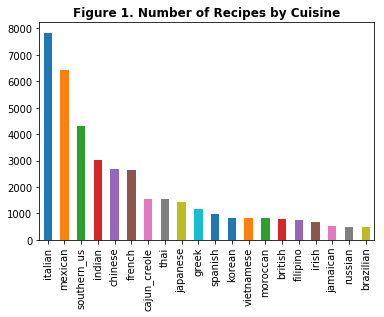

In [99]:
# make new dataframe containing number of recipes for each cuisine
recipe_count_cuisine = train_data.cuisine.value_counts().to_frame(name="Number of Recipes")
recipe_count_cuisine.plot.bar(y="Number of Recipes", legend=False)
plt.title("Figure 1. Number of Recipes by Cuisine", weight="bold")

plt.savefig("no_recipes_cuisine.png", bbox_inches="tight")

From the information and the bar chart above, we can see that the cuisine with the highest frequency is italian and the lowest is brazilian. Because the representation of cuisines is not uniform, the trained model might have a bias towards more well represented cuisines.

Next, we will take a look at the ingredients column and find out how many unique ingredients there are.

In [100]:
ingredients = {}

for recipe in train_data.ingredients:
    for ingredient in recipe:
        try:
            ingredients[ingredient] += 1
        except KeyError:
            ingredients[ingredient] = 1
            
print("Number of unique ingredients in the train dataset: {}".format(len(ingredients)))

Number of unique ingredients in the train dataset: 6714


In [101]:
ingredients_df = pd.DataFrame.from_dict(ingredients, orient='index', columns=['Number of Recipes'])
ingredients_df.sort_values(by='Number of Recipes', ascending=False, inplace=True)

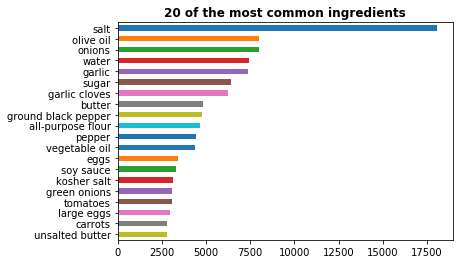

In [102]:
ingredients_df.head(n=20).plot.barh(y="Number of Recipes", legend=False)
plt.gca().invert_yaxis()
plt.title("20 of the most common ingredients", weight="bold")

plt.savefig("most_common_ingredients.png", bbox_inches="tight")

In [103]:
print("{} ingredients were used in only 1 recipe"
      .format(len(ingredients_df[ingredients_df['Number of Recipes'] == 1])))

1759 ingredients were used in only 1 recipe


Since there are 39774 recipes in the train datatset, this means that salt is used in more than half of the recipes. In addition, since there are 6714 unique ingredients, this suggests that we need to consider using a classifier that works with large number features. Nearly 1/5 of the ingredients were also used in only 1 recipe

Next, let us consider how the most common ingredients is distributed by cuisine.

In [104]:
# make an empty dataframe with ingredients for index and cuisines for columns
ingredients_by_cuisine = pd.DataFrame(0, index=ingredients.keys(), columns=cuisines)

# iterate over each recipe in the train dataset and populate the ingredients_by_cuisine dataframe
for index, recipe in train_data.iterrows():
    for ingredient in recipe.ingredients:
        ingredients_by_cuisine[recipe.cuisine][ingredient] += 1

In [105]:
def plot_ingredients_cuisine(df, name):
    """
    Plotting function to plot 5 most common ingredients by cuisine
    
    df: DataFrame to use for the plot
    name: name of the plot
    """
    
    plt.figure(figsize=(12,40))

    for i in range(len(cuisines)):
        plt.subplot(10,2,i+1)
        df[cuisines[i]].sort_values(ascending=False).head(n=5).plot.barh()
        plt.gca().invert_yaxis()
        plt.title(cuisines[i])
        plt.tight_layout()


    plt.suptitle(name, y=1.005, weight='bold')
    file = name.replace(" ", "_").lower() + ".png"
    plt.savefig(file, bbox_inches="tight")

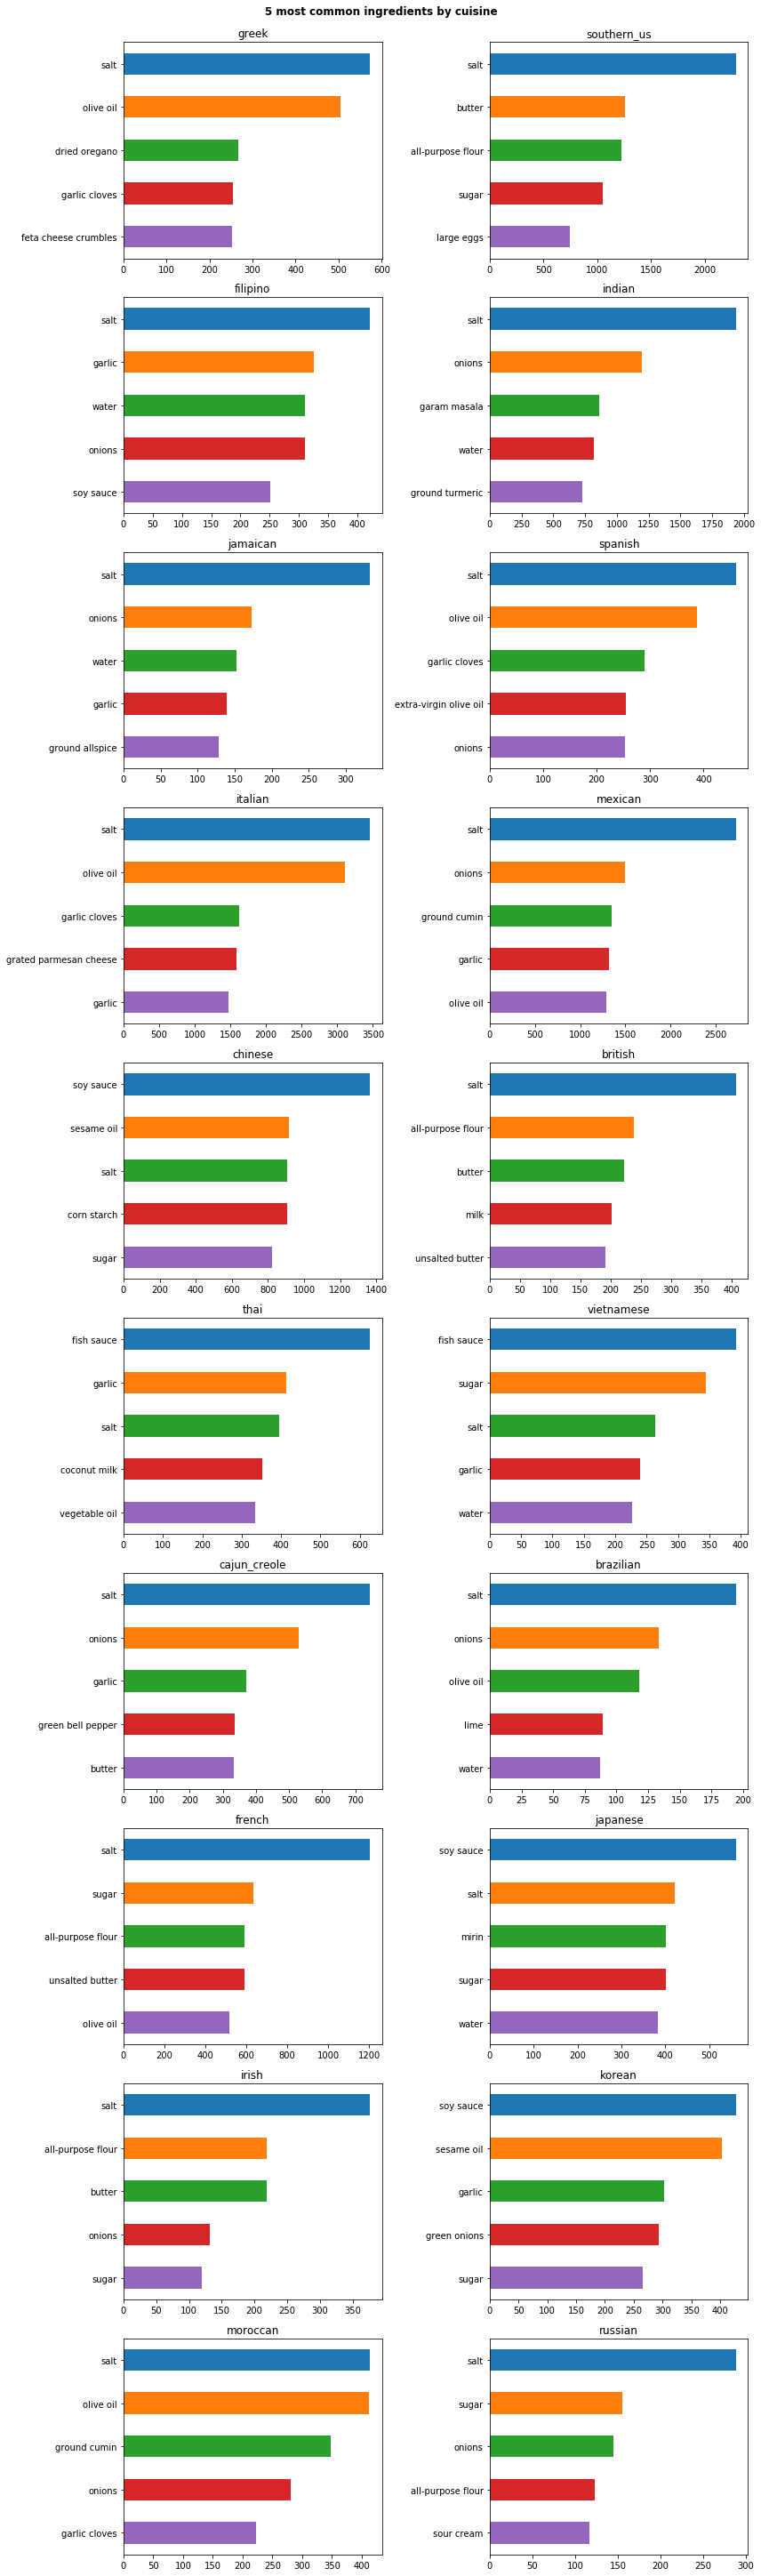

In [106]:
plot_ingredients_cuisine(ingredients_by_cuisine, "5 most common ingredients by cuisine")

As expected from the plot of common ingredients, salt is the most common ingredient in almost half the cuisines, only Asian cuisines such Chinese, Thai, Vietnamese, Japanese and Korean use another condiment in place of salt to salt their ingredients. Because, salt and its related condiments (soy sauce, and fish sauce) is the most common ingredient in the train dataset, it could suggest that this train dataset is also predominantly made up of savoury recipes. It could imply that the resulting model would not work as well on sweet recipes 

Considering the most common ingredients by cuisine is not as informative as it could be. As seen from the plots above, there are still many common ingredients used across cuisines. As such, it would be better to consider the most common ingredients in each cuisine that are unique to that cuisine. This would give us a better idea of what kind of ingredients tend to define a cuisine.

In [107]:
unique_ingredients_cuisine = pd.DataFrame(0, index=ingredients.keys(), columns=cuisines)

for cuisine in cuisines:
    # get all ingredients not in target cuisine
    other_cuisines = []
    for recipe in train_data[train_data.cuisine != cuisine].ingredients:
        other_cuisines += recipe
    other_cuisines = list(set(other_cuisines))

    # get ingredients unique to target cuisine
    unique = [ingredient for ingredient in ingredients.keys() if ingredient not in other_cuisines]
    
    # count number of times unique ingredients are used
    for recipe in train_data[train_data.cuisine == cuisine].ingredients:
        for ingredient in recipe:
            if ingredient in unique:
                unique_ingredients_cuisine[cuisine][ingredient] += 1

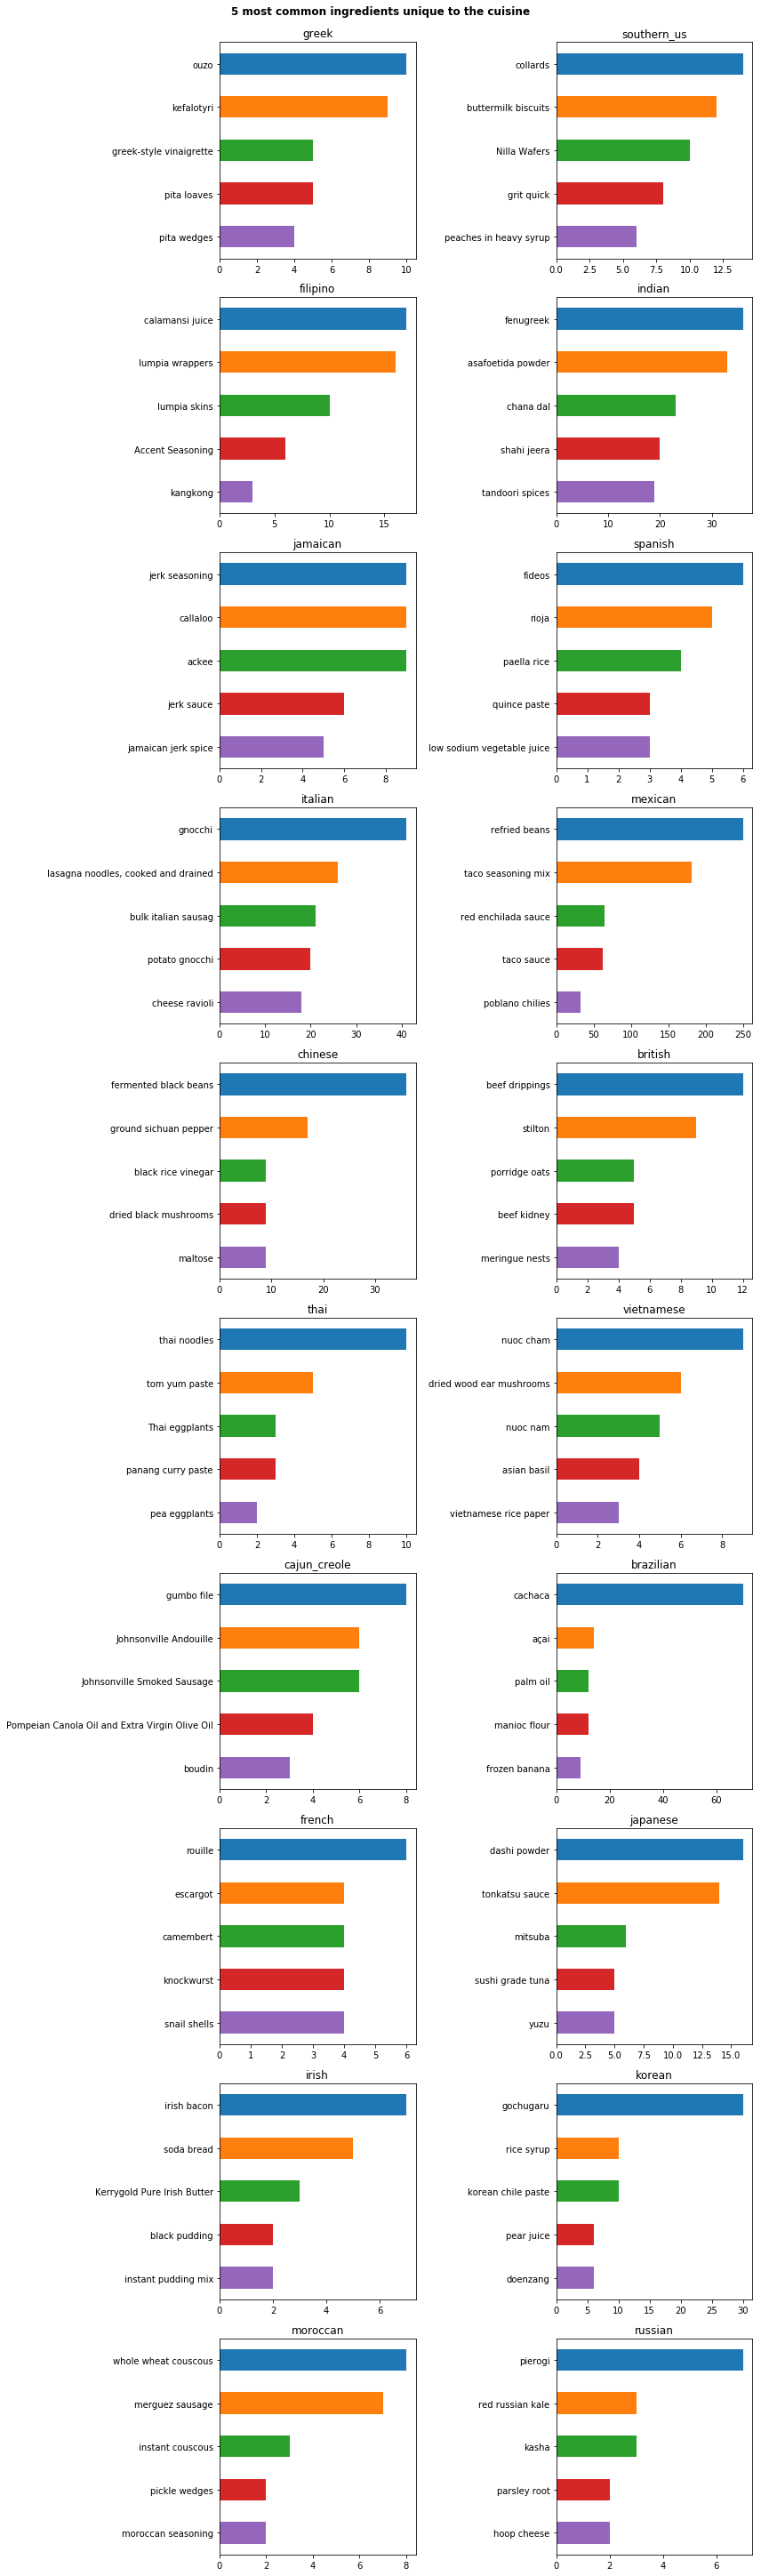

In [108]:
plot_ingredients_cuisine(
    unique_ingredients_cuisine, 
    "5 most common ingredients unique to the cuisine"
)

From this plot, it gives us a better idea about how to distinguish cuisines by recipe. For example, one thing that distinguishes Japanese cuisine from others it their use of [dashi powder](https://en.wikipedia.org/wiki/Dashi). Dashi is the stock base from which many Japanese recipes are based upon. As such this would also suggest that a model built from considering ingredients unique to the cuisine would be far more successful than a model built from the most common ingredients. To emphasis unique ingredients, we will make use of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) when preprocessing our train dataset.

Next, we will consider the number of ingredients in each recipe.

In [109]:
train_data.ingredients.str.len().describe()

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: ingredients, dtype: float64

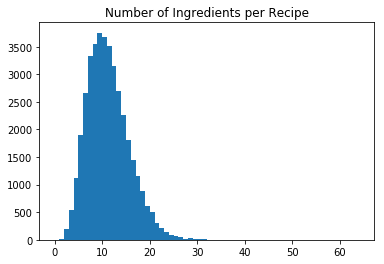

In [110]:
train_data.ingredients.str.len().hist(bins=range(max(train_data.ingredients.str.len())), grid=False)
plt.title("Number of Ingredients per Recipe")

plt.savefig("ingredients_per_recipe.png", bbox_inches="tight")

In [111]:
long_recipes = train_data[train_data.ingredients.str.len() > 30]

print("Number of recipes with more than 30 ingredients: {}".format(len(long_recipes)))
print("Cuisines of the recipes with more than 30 ingredients: \n{}".format(long_recipes.cuisine.value_counts()))

Number of recipes with more than 30 ingredients: 40
Cuisines of the recipes with more than 30 ingredients: 
mexican         12
indian           5
thai             3
italian          3
moroccan         2
southern_us      2
jamaican         2
cajun_creole     2
chinese          2
brazilian        2
japanese         1
filipino         1
french           1
vietnamese       1
spanish          1
Name: cuisine, dtype: int64


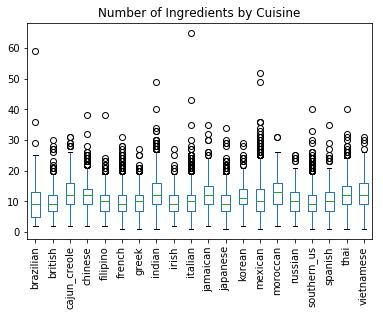

In [112]:
# make new dataframe containing number of ingredients for each recipe
no_ingredients = pd.concat([train_data.cuisine, train_data.ingredients.str.len()], axis=1)
no_ingredients.boxplot(column=['ingredients'], by=['cuisine'], grid=False, rot=90)
plt.suptitle("")
plt.xlabel("")
plt.title("Number of Ingredients by Cuisine")

plt.savefig("number_of_ingredients_by_cuisine.png", bbox_inches="tight")

From the boxplot, Moroccan cuisine has the highest average number of ingredients used per recipe. Most other cuisines have an average of 10 ingredients used, as expected by the histogram plot earlier. With the exception of Morrocan cuisines, it also appears that recipe length will not help in the classification of cuisines.

Our analysis of recipe length and common ingredients shows that we might not need to consider all ingredients when building our classifier. As such, in addition to preprocessing the text data for training, we will also use TF-IDF to extract the most relevant features for training.

----
## III. Methodology
### Data Preprocessing

In this project, cuisines will be the target variable to predict and ingredients will be the features that are consumed by the model. First, we will separate the columns in the train dataset into targets and features.



In [113]:
# split data into targets and features
targets = train_data.cuisine
features = train_data.ingredients

As both cuisines, and ingredients contain categorical data, we will need to preprocess it first by representing the categorical data as numeric values. We can use a simple label encoder to encode our targets; each cuisine will be represented by an integer.



In [114]:
# label encode targets
le = LabelEncoder()
targets_processed = le.fit_transform(targets)
print("Encoding for cuisines:")
for i, cuisine in enumerate(le.classes_):
    print(i, cuisine)

Encoding for cuisines:
0 brazilian
1 british
2 cajun_creole
3 chinese
4 filipino
5 french
6 greek
7 indian
8 irish
9 italian
10 jamaican
11 japanese
12 korean
13 mexican
14 moroccan
15 russian
16 southern_us
17 spanish
18 thai
19 vietnamese


In [115]:
print("First 5 targets before encoding: \n{}\n".format(targets.head().values))
print("First 5 targets after encoding: \n{}".format(targets_processed[:5]))

First 5 targets before encoding: 
['greek' 'southern_us' 'filipino' 'indian' 'indian']

First 5 targets after encoding: 
[ 6 16  4  7  7]


Next, we will preprocess the features. As mentioned in earlier, it would be good to use ingredients unique to the cuisine as features for the model. To achieve this, we will make of TF-IDF to preprocess our data. TF-IDF is a text preprocesing technique to extract features for bag of words classifiers. TF-IDF goes a step further than just couting the frequency of the word in each row by scaling the frequency with the inverse document frequency. This ensures that features which are not as well represented but important to that class, such as ingredients unique to the cuisine, are given higher weights.

Before applying TF-IDF on the features, we will first preprocess the features.

In [116]:
# function to preprocess feature data
def preprocess_features(features):
    """
    features: pandas series or array, each row contains an array of ingredients
    
    returns preprocessed features
    """
    features_processed = []
    for recipe in features:
        recipe_processed = []
        for ingredient in recipe:
            # convert to lower case
            ingredient = ingredient.lower()
            
            # remove non alphabetic characters
            ingredient = re.sub("[^a-z]"," ",ingredient)
            
            # remove units
            ingredient = re.sub("\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b", " ", ingredient)
            
            # remove redundant whitespaces between words
            ingredient = re.sub("\s+", " ", ingredient)
            
            # strip leading and trailing whitespaces
            ingredient = ingredient.strip()
            
            recipe_processed.append(ingredient)
        
        features_processed.append(recipe_processed)
    
    return features_processed

features_processed = preprocess_features(features)

In [117]:
# define TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_df=0.99, 
    norm='l2', 
    ngram_range=(1, 1),
    analyzer="word"
)

# fit and transform training data
features_processed = tfidf.fit_transform([str(i) for i in features_processed])

After preprocessing the features, we will now further split the training targets and features into a new set of training targets and features, and validation targets and features. The validation targets and features will be used to evaluate how well our model is performing.

In [118]:
features_train, features_valid, targets_train, targets_valid = train_test_split(
    features_processed, 
    targets_processed,  
    random_state=42
)

### Implementation

Next, we will develop a baseline classifier using the Decision Tree algorithm.

In [119]:
clf = DecisionTreeClassifier(
    random_state=42,
)
clf = clf.fit(features_train, targets_train)

In [120]:
print("Accuracy on features_train: {:3.2f}".format(clf.score(features_train, targets_train)))
print("Accuracy on features_valid: {:3.2f}".format(clf.score(features_valid, targets_valid)))

Accuracy on features_train: 1.00
Accuracy on features_valid: 0.62


From the performance on the training and validation dataset, the model is able to predict the train targets perfectly but does not do so well on the validation set. This suggests that the model is overfitting. Nevertheless, the model is performing better than the sample benchmark of `0.19267` on Kaggle. 

### Refinement

According to this [article](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f), it is possible that there could be better classifiers for this project. As such, one of the first steps at this stage will be to try other classifiers to determine the best classifier for this project

In [121]:
models = [
    LinearSVC(random_state=42),
    LogisticRegression(random_state=42),
    MultinomialNB(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=10, random_state=42),
]

accuracies = {}

for model in models:
    model_accuracy = cross_val_score(model, features_processed, targets_processed, cv=5)
    model_name = model.__class__.__name__
    accuracies[model_name] = model_accuracy

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


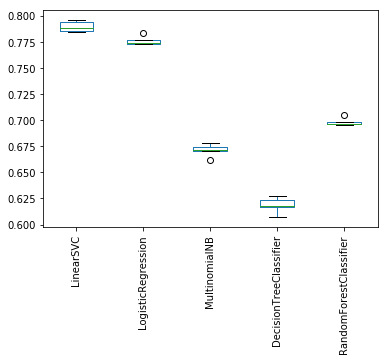

In [122]:
accuracies_df = pd.DataFrame.from_dict(accuracies)
accuracies_df.boxplot(grid=False, rot=90)

In [123]:
accuracies_df.mean(axis=0)

LinearSVC                 0.789637
LogisticRegression        0.775934
MultinomialNB             0.671218
DecisionTreeClassifier    0.618271
RandomForestClassifier    0.697993
dtype: float64

From the figure and the mean accuracy above, we can see that the LinearSVC algorithm works best for this project. We will proceed with the LinearSVC algorithm and tune it to improve its performance. We will consider 2 parameters, `C` and `max_iter` for tuning in this model. `max_iter` sets the maximum number of iterations that the algorithm completes when finding the hyperplane that best separates the different classes. `C` is the penalty parameter of the error term, a smaller C will ensure hyperplane separating classes will have a larger margin.

In [124]:
clf = LinearSVC(random_state=42)
params = {
    "max_iter": [50, 75, 100],
    "C": [0.5, 1.0, 1.5]
}

grid = GridSearchCV(
    estimator=clf, 
    param_grid=params, 
    cv=5,
    return_train_score=False
)
grid.fit(features_processed, targets_processed)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [50, 75, 100], 'C': [0.5, 1.0, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

In [125]:
pd.DataFrame(data=grid.cv_results_)[["param_C", "param_max_iter", "mean_fit_time", "mean_test_score", "rank_test_score"]]

,param_C,param_max_iter,mean_fit_time,mean_test_score,rank_test_score
0,0.5,50,1.943201,0.790667,1
1,0.5,75,1.582976,0.790667,1
2,0.5,100,1.600558,0.790667,1
3,1,50,1.836086,0.789636,4
4,1,75,2.020162,0.789636,4
5,1,100,2.145641,0.789636,4
6,1.5,50,2.013076,0.788279,9
7,1.5,75,2.516239,0.788304,7
8,1.5,100,2.488685,0.788304,7


From the grid search, it appears that `C` has a bigger impact on both training time and categorization accuracy. Changing `max_iter` did not seem to have an impact on either training time and categorization accuracy. Since the model achieved the best categorization score when `C` is 0.5 regardless of `max_iter`, we will set the final model's parameters at `{ C: 0.5, max_iter: 50 }` to achieve both low training speed and high validation accuracy.

In [126]:
clf_best = grid.best_estimator_

Before using our final model to predict the cuisines for the test dataset, we will take a look at the features that the classifier has found to be the most important when determining each cuisine

In [127]:
weights = clf_best.coef_

# built ingredients by cuisine df based on feature names from TF-IDF and model coefficients
features_names = tfidf.get_feature_names()
unique_ingredients_cuisine_model = pd.DataFrame(weights, columns=features_names, index=le.classes_)
unique_ingredients_cuisine_model = unique_ingredients_cuisine_model.transpose()


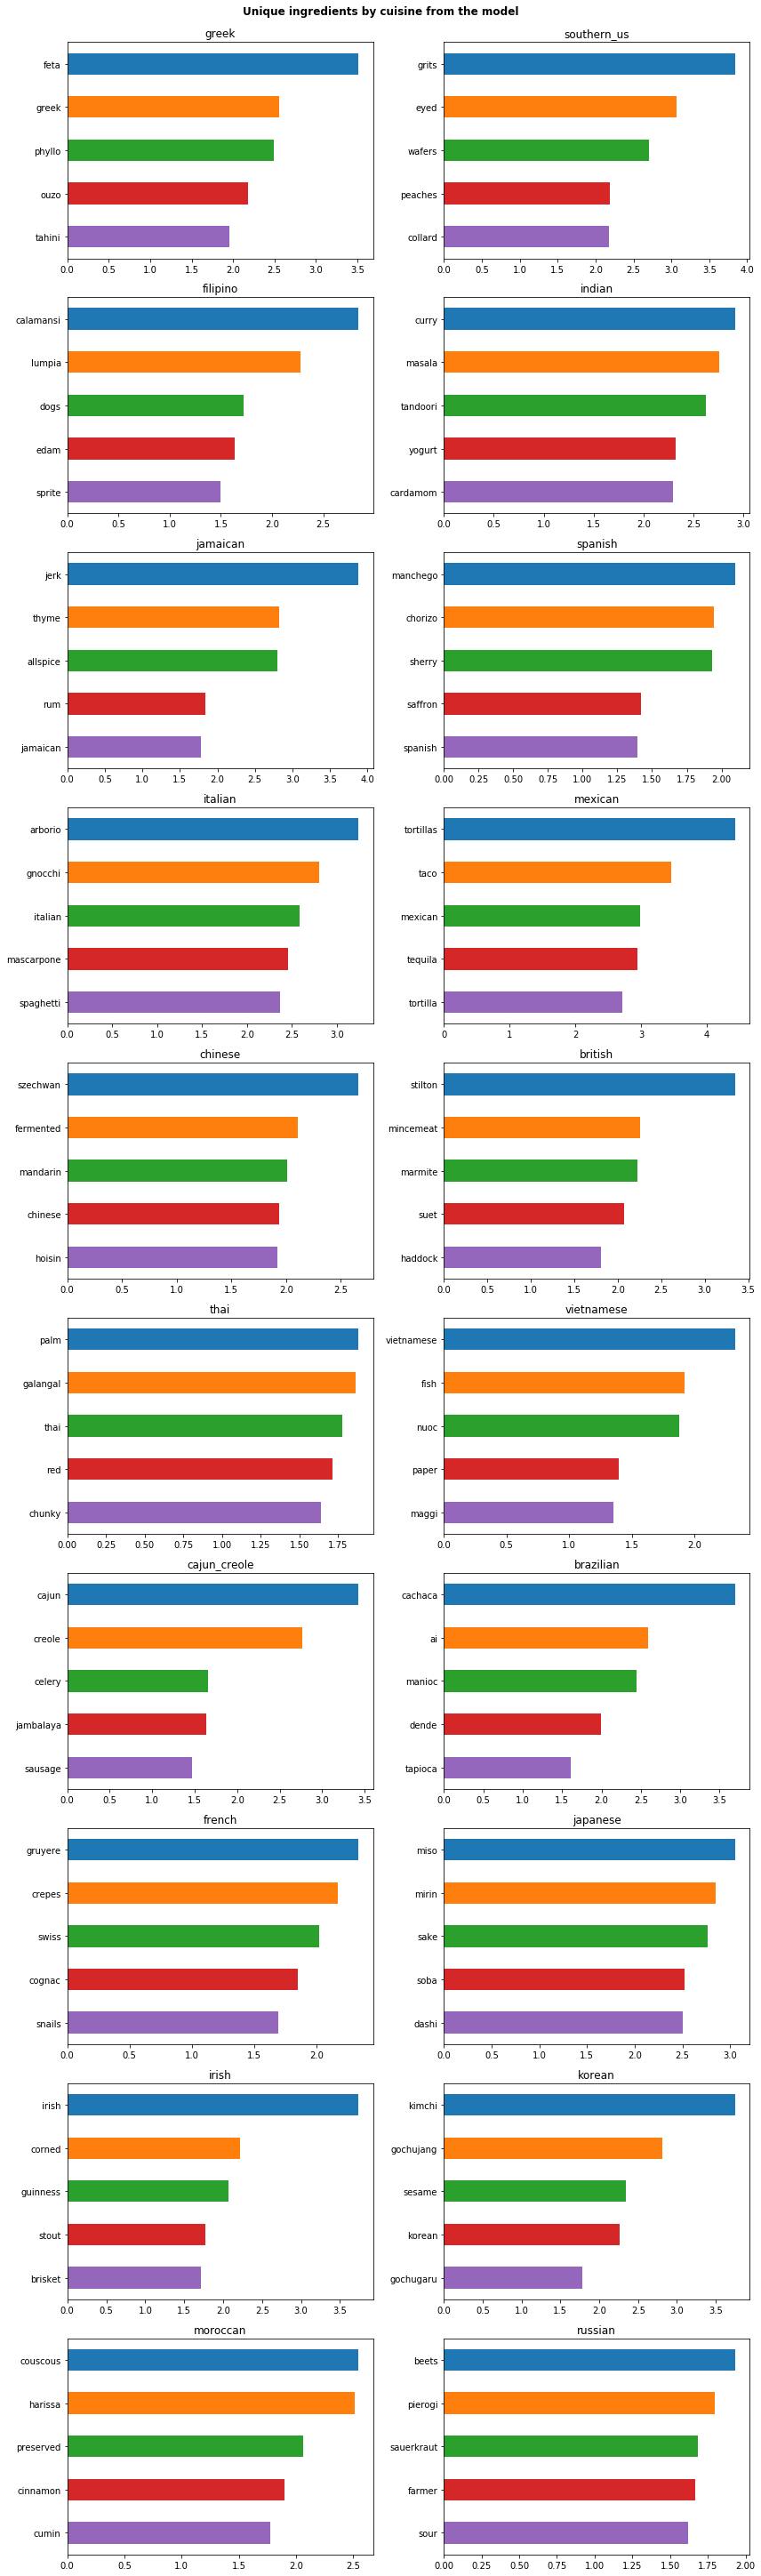

In [128]:
plot_ingredients_cuisine(
    unique_ingredients_cuisine_model, 
    name="Unique ingredients by cuisine from the model"
)

From the weights obtain by the model, some of the cuisines had some expected features while some were surprising. For example, it was not surprising to see that Miso was the ingredient that had the highest weight in Japanese cuisine. After all, both Miso and Dashi form the foundation of almost all of Japanese cuisine since they are used to make basic stocks. Others such as the Szechwan ingredient in Chinese cuisine, the Irish ingredient in Irish cuisine were surprising because Szechwan is a region, not a ingredient while Irish would refer to the people or the culture. This could be a result of using Unigrams or n-grams of size 1 when using TF-IDF to extract features. 

Finally, we will make a prediction on our test dataset and make a submission to the Kaggle competition.

In [129]:
# preprocess test features
features_test = test_data.ingredients

features_test_processed = preprocess_features(features_test)
features_test_processed = tfidf.transform([str(i) for i in features_test_processed])

In [130]:
# make predictions
targets_test_processed = clf_best.predict(features_test_processed)
targets_test = le.inverse_transform(targets_test_processed)

In [131]:
# prepare submission file
results_df = pd.DataFrame(data=test_data.id)
results_df['cuisine'] = targets_test
results_df.to_csv("submission.csv", index=False)